In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize._numdiff import approx_derivative
from scipy.integrate import solve_ivp

from dynamics import LowThrustTwoBody
from units import *
from state import Index as I

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
MU = 132712440018  # km^3/s^2
g0 = 9.8065e-3  # km/s^2
m0 = 4000  # kg
Tmax = 0.32e-3  # kN
Isp = 3000  # s

rv0 = np.array([
    -3637871.081, 147099798.784, -2261.441,
    -30.265097, -0.8486854, 0.0000505
])  # [km] and [km/s]

# t0 = 56284 * 86400  # MJD * sec
t0 = 0  # MJD * sec
dt = 3534 * 86400 / TU
tn = t0 + dt

# normalize
rv0[:3] /= DU
rv0[3:] /= (DU / TU)
m0 /= MaU
MU /= (DU ** 3 / TU ** 2)
Tmax /= (MaU * DU / TU ** 2)
Isp /= TU
g0 /= (DU / TU ** 2)

np.random.seed(0)
costate = np.random.rand(7) * 0.1
Phi0 = np.eye(14)
X0 = np.r_[rv0, m0, costate, Phi0.ravel()]
print(X0.shape)

(210,)


In [23]:
dyn = LowThrustTwoBody(
    mu=MU, thrust_max=Tmax, Isp=Isp, g0=g0, rho=1 
)
dyn.variation = True
print(dyn.time_derivative(t0, X0).shape)

(210,)


In [24]:
sol = solve_ivp(
    dyn.time_derivative, (t0, tn), X0,
    method='DOP853', rtol=1e-9, atol=1e-9,
    t_eval=np.linspace(t0, tn, 10000)
)


In [25]:
def shooting(rv_f, lmf, rv_t):
    drv = rv_f - rv_t
    return np.array([*drv, lmf])

In [26]:
# rv = sol.y[I.rv]
# m = sol.y[I.m].ravel()
# lr = sol.y[I.lr]
# lv = sol.y[I.lv]
# lm = sol.y[I.lm].ravel()

In [27]:
sol.y[14:].reshape(14, 14, -1)[..., -1][I.i(I.m, I.l)]

array([[-0.57409322,  0.06004445, -0.00278844,  0.0602999 , -0.58126287,
        -0.00333761, -0.04001568]])

In [28]:
rv_t = np.array([
    -1.26725023, 3.09190622, 0.40526029, 
    -0.3132259 , -0.19178898, 0.0687792
])

def evaluate_sol(costate0, variation=False, dense=False):
    if variation:
        x0 = np.r_[rv0, m0, costate0, Phi0.ravel()]
    else:
        x0 = np.r_[rv0, m0, costate0]
    dyn.variation = variation
    sol = solve_ivp(
        dyn.time_derivative, (t0, tn), x0,
        method='DOP853', rtol=1e-9, atol=1e-9,
        t_eval=np.linspace(t0, tn, 10000) if dense else None
    )
    return sol

def objective(costate0, dense=False):
    sol = evaluate_sol(costate0, dense)
    rv = sol.y[I.rv]
    lm = sol.y[I.lm].ravel()
    obj_val = shooting(rv[:, -1], lm[-1], rv_t)
    # print(obj_val)
    return obj_val

def dobj_dcostate0(costate0):
    sol = evaluate_sol(costate, variation=True)
    rv = sol.y[I.rv]
    lm = sol.y[I.lm].ravel()
    obj_val = shooting(rv[:, -1], lm[-1], rv_t)
    dXdX0 = sol.y[14:].reshape(14, 14, -1)
    drf_dl0 = dXdX0[..., -1][I.i(I.r, I.l)]
    dvf_dl0 = dXdX0[..., -1][I.i(I.v, I.l)]
    dlmf_dl0 = dXdX0[..., -1][I.i(I.lm, I.l)].ravel()
    partial = np.vstack((drf_dl0, dvf_dl0, dlmf_dl0))
    return partial, obj_val

In [29]:
objective(costate)

array([-7.69487285e-01, -1.98124986e+01,  4.95237599e-03,  8.43875588e-01,
       -7.68916247e-01, -2.40076032e-02, -2.47696120e+01])

In [30]:
num_diff = approx_derivative(objective, costate)
theo_diff = dobj_dcostate0(costate)

In [31]:
theo_diff

(array([[-6.51046616e+02,  1.53224655e+02, -1.47738357e+01,
          7.87898131e+01, -7.62358275e+02,  1.60248397e+01,
         -3.63755608e+01],
        [ 6.41261520e+00, -4.91298404e+00,  5.02016311e-01,
         -2.83361166e+00,  4.79350660e+00, -5.24535218e-01,
         -7.17917170e-02],
        [-1.23956886e+01,  2.53749499e+00,  5.72913240e+00,
          1.95893828e+00, -1.39305410e+01,  1.02301648e+00,
         -3.57086979e-01],
        [-3.77822946e+01,  9.10961851e+00, -8.83482922e-01,
          4.66643288e+00, -4.47224023e+01,  9.48089755e-01,
         -2.10179087e+00],
        [-2.43738686e+01,  5.74515405e+00, -5.15957709e-01,
          3.08787614e+00, -2.88639344e+01,  5.71920216e-01,
         -1.37637282e+00],
        [-4.16273553e-01,  5.78651160e-02,  4.20282686e-01,
          8.01804766e-02, -4.34096075e-01,  2.94680850e-01,
          1.25196883e-02],
        [-2.12989733e+02,  3.29136980e+00,  2.49705687e+00,
          3.12055012e+01, -2.02194641e+02, -4.61452962e+00

In [32]:
num_diff - theo_diff[0]

array([[-1.81973523e-04, -7.29608400e-04,  2.17050792e-04,
         1.61965166e-04,  1.27553901e-03, -1.64786716e-04,
        -2.13071253e-07],
       [-4.70459588e-05,  2.82240054e-05, -6.85815404e-06,
         1.10744730e-06, -8.88065061e-05,  5.68617141e-06,
        -2.40628872e-06],
       [-3.98174232e-06, -1.25913664e-05, -5.06454292e-06,
         5.93255086e-06,  2.29033865e-05,  6.51895418e-06,
        -5.35347235e-08],
       [-8.79657939e-06, -4.38363103e-05,  1.30206267e-05,
         9.42921202e-06,  7.82269041e-05, -9.91093588e-06,
         8.08798752e-08],
       [-9.49629116e-06, -2.56476538e-05,  7.75287504e-06,
         6.15142391e-06,  4.26300445e-05, -5.86426436e-06,
        -1.46265991e-07],
       [ 5.70042747e-08, -1.28436378e-07, -2.35611147e-07,
         1.09903936e-07,  3.36799527e-07,  2.60932628e-07,
         3.42092728e-09],
       [ 2.68329105e-05,  1.30843912e-04, -5.21935784e-05,
        -2.05818819e-05, -2.30773247e-04,  4.33995251e-05,
        -4.5744997

In [33]:
%%timeit
objective(costate)
# 574 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 43.1 ms ± 70 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

42.7 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%%timeit
dobj_dcostate0(costate)
# 573 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

570 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
from scipy.optimize import root

In [36]:
# %%time
# max_trial = 100
# for i in range(max_trial):
#     costate0 = np.random.rand(7) * 200 - 100
#     rsol = root(
#         objective, costate0, jac=dobj_dcostate0
#     )
#     success = rsol.success
#     print(f"trial {i}, {success}, {(rsol.nfev, rsol.njev)}, {costate0}")
#     if success:
#         break

In [37]:
import pygmo as pg

In [38]:
class Objective:
    def fitness(self, x):
        obj_vec = objective(x)
        return [obj_vec @ obj_vec]
        # return obj_vec
    
    # def get_nobj(self):
    #     return 7

    # def gradient(self, x):
    #     jac, obj_vec = dobj_dcostate0(x)
    #     return jac.T @ obj_vec * 2
    #     # return jac
    
    def get_bounds(self):
        return ([-10] * 7, [10] * 7)


In [39]:
obj = Objective()
prob = pg.problem(obj)

method = pg.cmaes(gen=1000, ftol=1e-9)
# method = pg.de(gen=1000, ftol=1e-9)
# method = pg.pso(gen=1000, ftol=1e-9)

# method = pg.ipopt()
# method.set_numeric_option("tol",1e-9)

algo = pg.algorithm(method)
algo.set_verbosity(10)
pop = pg.population(prob, 10)
# archi = pg.archipelago(n=64, algo=algo, prob=prob, pop_size=1)

In [40]:
pop = algo.evolve(pop)
# archi.evolve()
# archi.wait()

CMAES 4 PaGMO: 
mu: 5 - lambda: 10 - mueff: 3.1673 - N: 7
cc: 0.374002 - cs: 0.340687 - c1: 0.0277557 - cmu: 0.0352399 - sigma: 0.5 - damps: 1.34069 - chiN: 2.55383

   Gen:        Fevals:          Best:            dx:            df:         sigma:
      1              0    1.59305e+06        29.1986    7.33408e+08            0.5
     11            100         151009        18.7041    1.52991e+08       0.320125
     21            200        40176.3         10.129    6.41793e+07        0.18175
     31            300        1878.36         6.6414    1.80339e+06       0.161247
     41            400        503.425        5.13256    9.85865e+06       0.141727
     51            500        845.178        2.55977    3.23839e+06      0.0973198
     61            600        1223.05        3.58189    4.36676e+06        0.11034
     71            700        2254.24         6.3036         303024       0.104121
     81            800        1678.51        9.98107        80334.7       0.109151
    

In [41]:
from scipy.optimize import OptimizeResult
from throttle_function import throttle_tanh

In [42]:
def evaluate_auxiliary(sol):
    # evaluate the auxiliary variables from integration results
    n = sol.t.shape[0]
    rv = sol.y[I.rv]
    m = sol.y[I.m].ravel()  # (n, )
    lr = sol.y[I.lr]
    lv = sol.y[I.lv]  # (3, n)
    lm = sol.y[I.lm].ravel()

    sf = dyn.c * np.linalg.norm(lv, axis=0) / m + lm - 1
    u_tanh = throttle_tanh(sf, dyn.rho)
    u = 0.5 * (1 + np.sign(sf))
    sol_aux = OptimizeResult(
        t=sol.t, rv=rv, sf=sf, u_tanh=u_tanh, u=u,
    )
    return sol_aux

In [43]:
print(pop.champion_x)
print(objective(pop.champion_x))

[-0.01601051  0.92099662 -0.05402723 -1.12491341 -0.03068235 -0.10126746
  0.81285513]
[ 5.32615827e-06 -1.03624781e-05 -5.73286242e-06  2.63525846e-06
 -3.75643617e-07  5.87279979e-06  6.55056125e-06]


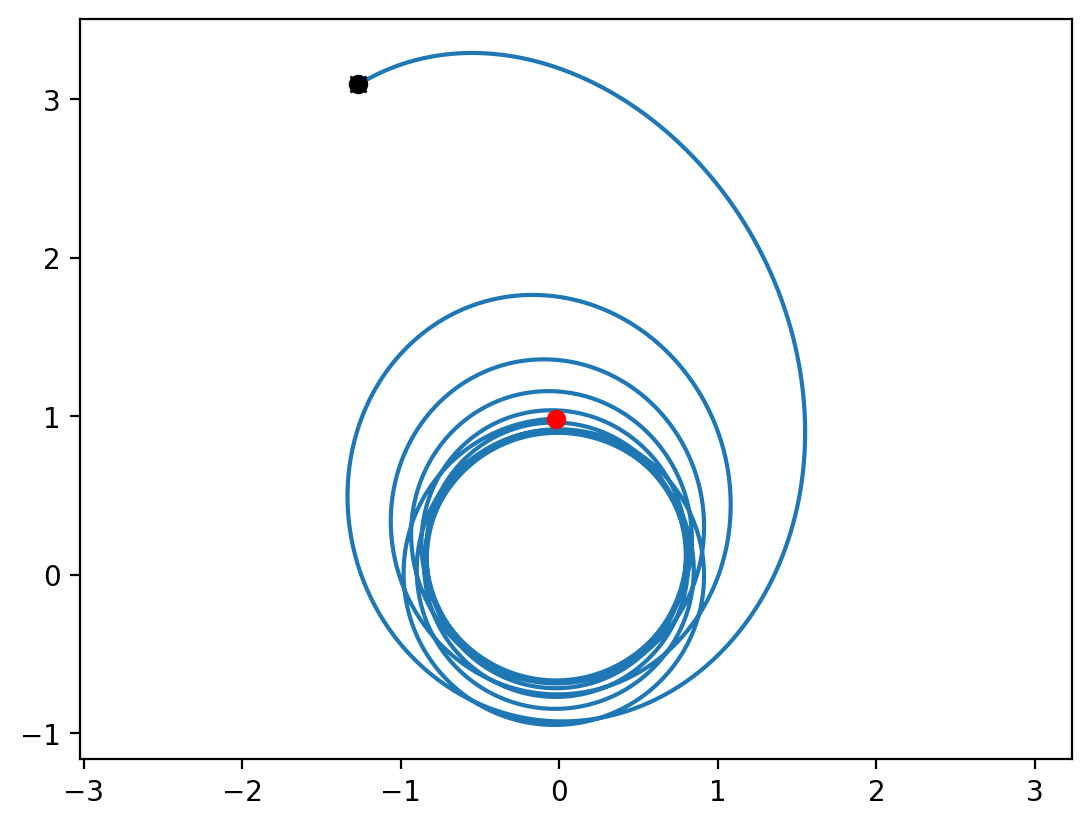

In [44]:
sol = evaluate_sol(pop.champion_x, dense=True)
rv = sol.y[I.rv]
plt.plot(rv[0], rv[1], '-')
plt.plot(rv[0, 0], rv[1, 0], 'o', c='r')
plt.plot(rv[0, -1], rv[1, -1], 'o', c='k')
plt.plot(rv_t[0], rv_t[1], 'x', c='k')
plt.axis('equal')
plt.show()

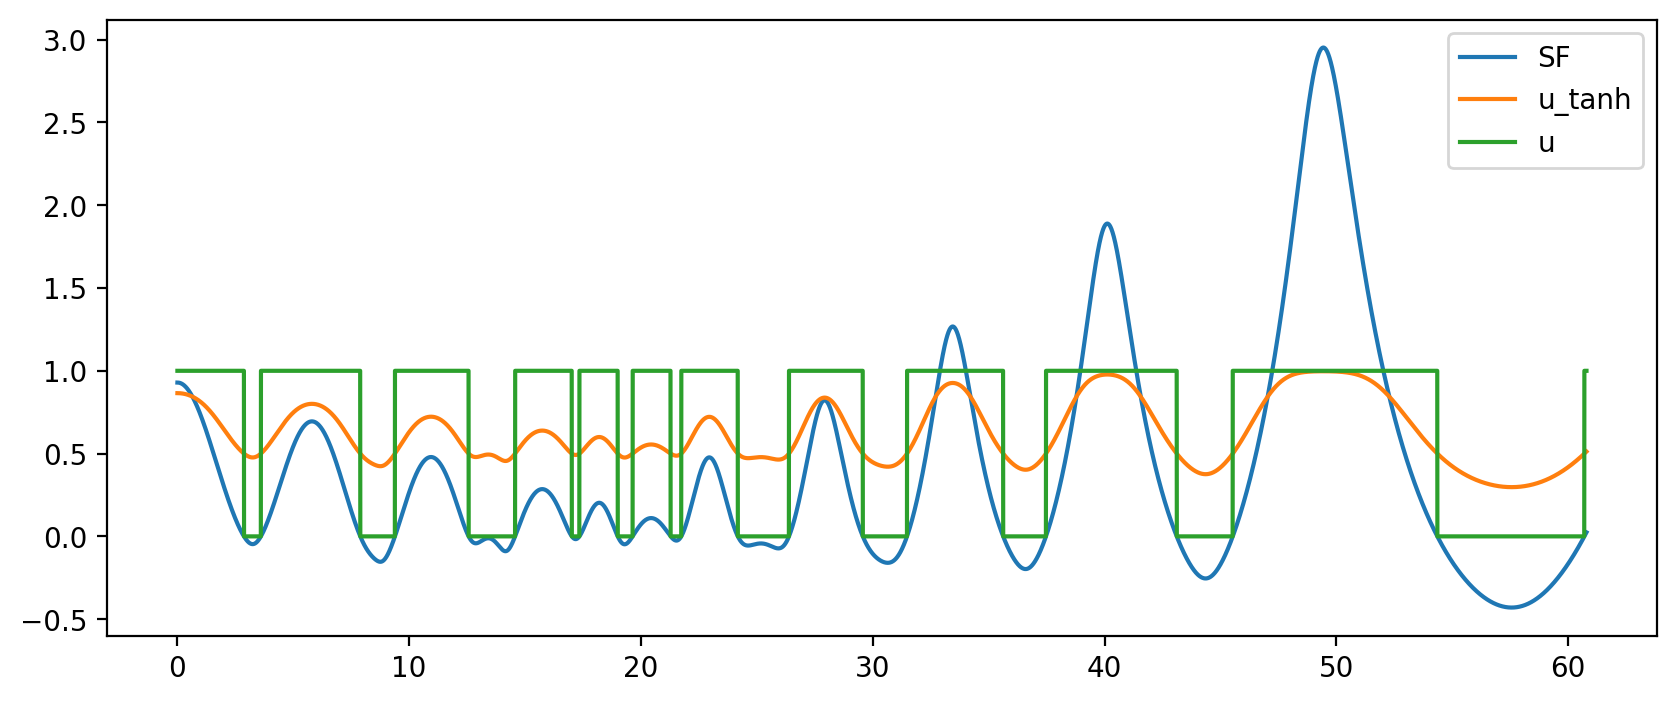

In [45]:
sol_ax = evaluate_auxiliary(sol)
plt.figure(figsize=(10, 4))
plt.plot(sol_ax.t, sol_ax.sf, label='SF')
plt.plot(sol_ax.t, sol_ax.u_tanh, label='u_tanh')
plt.plot(sol_ax.t, sol_ax.u, label='u')
plt.legend()